In [2]:
import os
import cv2
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import callbacks, layers, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix,roc_curve, auc
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Dense, Add, Lambda, Concatenate, Dropout
# Notebook magic
%matplotlib inline

In [ ]:
# Check if GPU available
!nvidia-smi

Wed Oct 11 01:11:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    45W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# Define Hyperparameters
input_shape = (224, 224, 3)
num_classes = 3
batch_size = 32

In [5]:
# Define a function to load images and labels from a directory
def load_data_from_directory(directory):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith(".jpg"):  # Adjust file extension as needed
                img = cv2.imread(os.path.join(class_dir, filename))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, input_shape[:2])  # Resize to the desired input shape
                label = class_names.index(class_name)
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

In [6]:
# Load train, validation, and test data
train_images, train_labels = load_data_from_directory('/content/drive/MyDrive/Training/Data/Data_file/train')
validation_images, validation_labels = load_data_from_directory('/content/drive/MyDrive/Training/Data/Data_file/val')
test_images, test_labels = load_data_from_directory('/content/drive/MyDrive/Training/Data/Data_file/test')

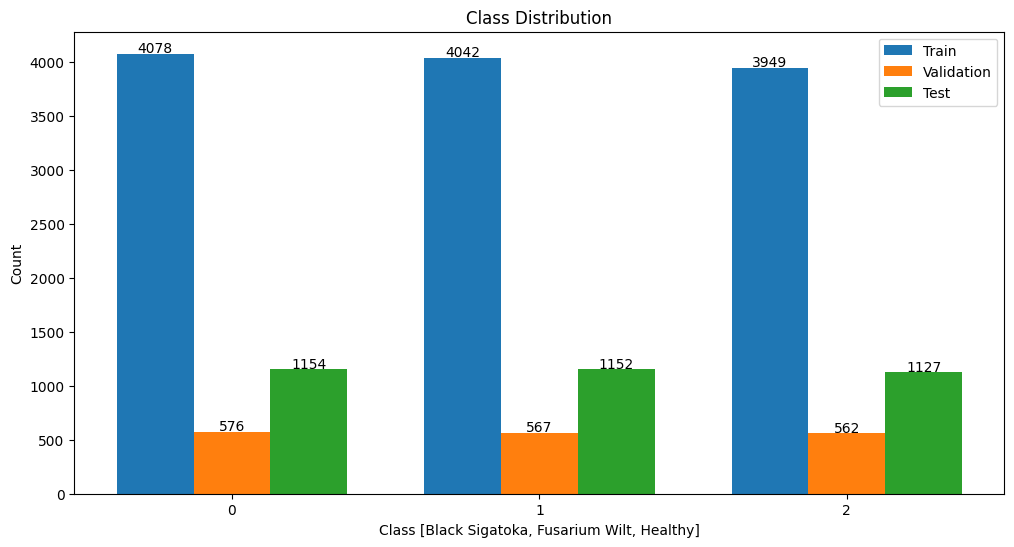

In [10]:
#Counting the images and display in graph
def plot_class_distribution(train_labels, validation_labels, test_labels):
    # Calculate class counts for each set
    train_class_counts = np.bincount(train_labels)
    validation_class_counts = np.bincount(validation_labels)
    test_class_counts = np.bincount(test_labels)

    # Get the number of unique classes
    num_classes = len(train_class_counts)

    # Generate class labels (class names)
    class_labels = [str(i) for i in range(num_classes)]

    # Create a bar chart to display class distribution
    x = np.arange(num_classes)  # x-axis values
    width = 0.25  # Width of bars

    plt.figure(figsize=(12, 6))
    plt.bar(x - width, train_class_counts, width, label='Train')
    plt.bar(x, validation_class_counts, width, label='Validation')
    plt.bar(x + width, test_class_counts, width, label='Test')

    plt.xlabel('Class [Black Sigatoka, Fusarium Wilt, Healthy]')
    plt.ylabel('Count')
    plt.title('Class Distribution')
    plt.xticks(x, class_labels)

    # Add labels above the bars
    for i in range(num_classes):
        plt.text(x[i] - width, train_class_counts[i] + 10, str(train_class_counts[i]), ha='center')
        plt.text(x[i], validation_class_counts[i] + 10, str(validation_class_counts[i]), ha='center')
        plt.text(x[i] + width, test_class_counts[i] + 10, str(test_class_counts[i]), ha='center')

    plt.legend()
    plt.show()

# Usage
plot_class_distribution(train_labels, validation_labels, test_labels)

In [12]:
# One-hot encode the class labels
train_labels_onehot = to_categorical(train_labels, num_classes=num_classes)
validation_labels_onehot = to_categorical(validation_labels, num_classes=num_classes)
test_labels_onehot = to_categorical(test_labels, num_classes=num_classes)

In [13]:
# Define data generators for train, validation, and test sets
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Training/Data/Data_file/train',  # Train set
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)
validation_generator = val_datagen.flow_from_directory(
    '/content/drive/MyDrive/Training/Data/Data_file/val',  # Validation set
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Training/Data/Data_file/test',  # Test set
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 12069 images belonging to 3 classes.
Found 1705 images belonging to 3 classes.
Found 3433 images belonging to 3 classes.


In [14]:
#Load base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape= input_shape)

9406464/9406464 [==============================] - 1s 0us/step


In [15]:
# Freeze trainable layers in the base model
for layer in base_model.layers:
    layer.trainable = False

In [16]:
# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

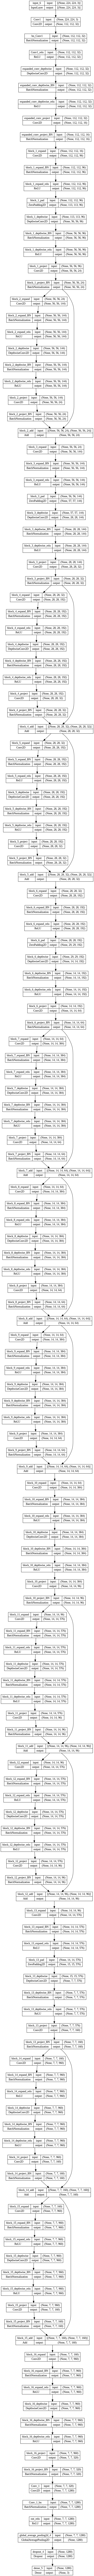

In [ ]:
from tensorflow.keras.utils import plot_model
# Visualize the model architecture and save it to a file
plot_model(model, to_file='mobilenetv2.png', show_shapes=True)

In [17]:
# Create optimizer with custom parameters
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00002, momentum=0.9,name='RMSprop' )

# Compile
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [18]:
# Define the early stopping and learning rate reduction callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10, restore_best_weights=True)

In [19]:
# Train the model
import time
start_time = time.time()
epochs = 100
history = model.fit(train_images,train_labels_onehot,batch_size=batch_size,epochs=epochs,
                    validation_data=(validation_images, validation_labels_onehot), callbacks=[early_stopping]
)
end_time = time.time()
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")

Epoch 1/100
378/378 [==============================] - 30s 50ms/step - loss: 0.5634 - accuracy: 0.7692 - val_loss: 0.4326 - val_accuracy: 0.8170
Epoch 2/100
378/378 [==============================] - 17s 45ms/step - loss: 0.3431 - accuracy: 0.8657 - val_loss: 0.3221 - val_accuracy: 0.8739
Epoch 3/100
378/378 [==============================] - 17s 45ms/step - loss: 0.2974 - accuracy: 0.8874 - val_loss: 0.2994 - val_accuracy: 0.8827
Epoch 4/100
378/378 [==============================] - 17s 45ms/step - loss: 0.2682 - accuracy: 0.8965 - val_loss: 0.3016 - val_accuracy: 0.8891
Epoch 5/100
378/378 [==============================] - 17s 45ms/step - loss: 0.2494 - accuracy: 0.9055 - val_loss: 0.2599 - val_accuracy: 0.9026
Epoch 6/100
378/378 [==============================] - 17s 45ms/step - loss: 0.2388 - accuracy: 0.9062 - val_loss: 0.2532 - val_accuracy: 0.9015
Epoch 7/100
378/378 [==============================] - 17s 45ms/step - loss: 0.2237 - accuracy: 0.9147 - val_loss: 0.2279 - val_ac

In [20]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels_onehot)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

108/108 [==============================] - 4s 39ms/step - loss: 0.8260 - accuracy: 0.7297
Test Loss: 0.8260
Test Accuracy: 0.7297


In [21]:
# Generate confusion matrix
predicted_labels = model.predict(test_images)
predicted_labels = np.argmax(predicted_labels, axis=1)

108/108 [==============================] - 5s 37ms/step


In [22]:
# Generate classification report
class_labels = sorted(os.listdir('/content/drive/MyDrive/Training/Data/Data_file/test'))  # Get class names from the test directory
report = classification_report(test_labels, predicted_labels, target_names=class_labels)
print(report)

                precision    recall  f1-score   support

BLACK_SIGATOKA       0.61      0.89      0.72      1154
 FUSARIUM_WILT       0.78      0.37      0.50      1152
       HEALTHY       0.87      0.94      0.90      1127

      accuracy                           0.73      3433
     macro avg       0.75      0.73      0.71      3433
  weighted avg       0.75      0.73      0.71      3433



108/108 [==============================] - 4s 38ms/step


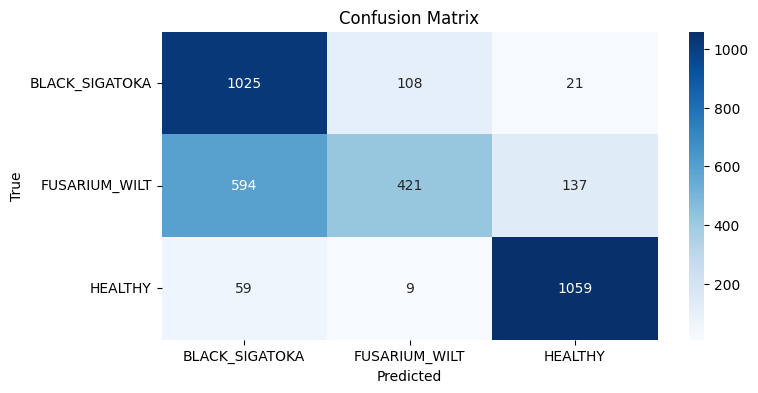

In [23]:
confusion_mtx = confusion_matrix(test_labels, predicted_labels)
# Plot confusion matrix
plt.figure(figsize=(8, 4))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
# Generate confusion matrix
predicted_labels = model.predict(test_images)
predicted_labels = np.argmax(predicted_labels, axis=1)
plt.title('Confusion Matrix')
plt.show()

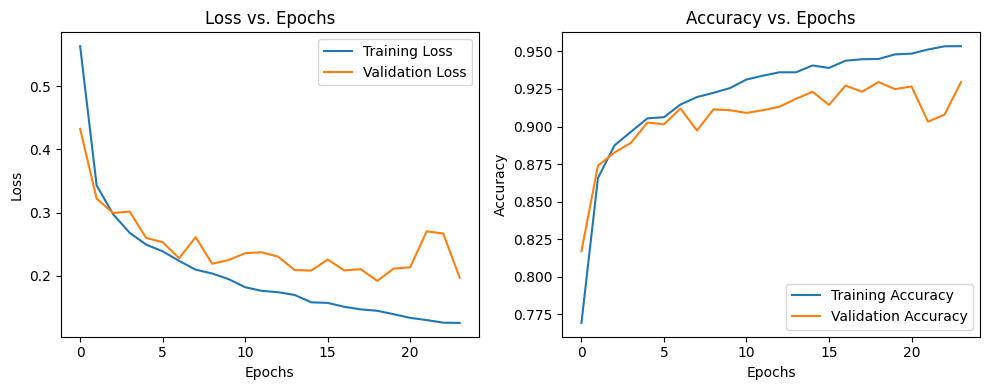

In [24]:
#Plot loss graphs
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()